# Implementing Black Box AW-SGD

In [1]:
# Imports of all packages used trough out this tutorial
%matplotlib inline
from __future__ import print_function
import os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from scipy.stats import norm
import math

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Linear Regression

In [2]:
N = 1000
D = 1
sigma = 0.2
alpha = 0.01
iters = 500
batch_size = 10

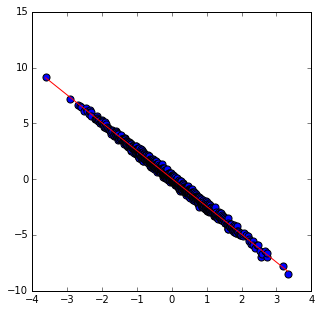

In [3]:
def GenData(N,D,sigma):
    """Generate Linear Data with Gaussian Noise
        N - Number of Data
        D - Dimension
        simga - noise level """
    X = np.random.randn(N,D)
    w_true = np.random.randn(D+1,1)
    # Sort the X's
    X = np.sort(X,axis = 0)
    # Add Biases
    X = np.concatenate((X, np.ones((N, 1))), axis=1)
    # Get Y
    y = np.dot(X,w_true) + sigma*np.random.randn(N,1)
    return w_true, X, y
    
w_true, X, y = GenData(N,D,sigma)

plt.figure(figsize=(5, 5))
# Plot the data
plt.scatter(X[:, 0], y, s=50)
# Plot real line
plt.plot(X[:, 0], np.dot(X, w_true), color='r')
plt.show()


In [6]:
# Define all the functions that we'll need

def lin_reg_grad(X,y,w):
    """Returns Gradient of Square Loss
    """

    if np.shape(X)[1] != D+1:
        raise Exception('Input Matrix wrong Dimension')
        
    N = np.shape(X)[0]
    gram = np.dot(X.transpose(),X)
    grad = (np.dot(gram,w) - np.dot(X.transpose(),y))/N
    return grad

def cosine_similarity(vec1,vec2):
    """Calculate the cosin similarity between 2 vectors"""
    return np.dot(vec1.T,vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2))
    
def error(X,y,w):
    """Returns the Square Error"""
    N = np.shape(X)[0]
    res = np.dot(X,w) - y
    cost = np.dot(res.transpose(),res)/N
    return cost

def get_index(N,batch_size):
    return np.random.randint(N - batch_size + 1)

def get_weighted_index(N,mean = 50):
    """Returns an index by rounding a sample from a gaussian
    along with it's weight and the gaussian random variable"""
    sigma = N/10
    s = np.random.randn()
    z = s*sigma + mean
    index = max(0,min(N-1,int(z)))
    if z < -0.5:
        weight = 0.0
    elif z > N + 0.5:
        weight =0.0
    else:
        weight = 1.0/norm.pdf(z,mean,sigma)
    return index,weight,z
    
def gradient_descent(X,y,w,mu):
    "Performs one step of Gradient descent on square loss objective"
    w = w - mu*lin_reg_grad(X,y,w)
    return w

def stochastic_gradient_descent(X,y,w,mu,batch_size, index):
    "Performs one step of batch SGD"
    x_batch = X[index:index+batch_size, :]
    y_batch = y[index:index+batch_size]
    return gradient_descent(x_batch,y_batch,w,mu)

def weighted_stochastic_gradient_descent(X, y, w, mu, batch_size, index, weight):
    "Performs one step of weighted SGD with guassian weighting"
    mu = mu*weight
    return stochastic_gradient_descent(X,y,w,mu,batch_size,index)

def adaptive_weighted_stochastic_gradient_descent(X, y, w, mu, batch_size, tau, index, weight,z,step, base_line=0.0,
                                                  rate = 0.000000001):
    "Performs AWSGD and returns both tau,w and the base line"
    w_new = weighted_stochastic_gradient_descent(X, y, w, mu, batch_size, index, weight)
    
    d = (w - w_new)/mu
    v = np.linalg.norm(d)**2
    tau = tau - rate*(v - base_line)*(z-tau)
    base_line = base_line - (1.0/(step + 1))*(base_line - v)
    w = w_new
    return w,tau,base_line


def learning_rate_generator(initial_rate,time,cst):
    return initial_rate/(1 + initial_rate*time*cst)


In [7]:
# Perform gd,sgd,wsgd and awsgd

num_iter = 100

errors_gd = np.zeros([num_iter,1])
errors_sgd = np.zeros([num_iter,1])
errors_wsgd = np.zeros([num_iter,1])
errors_awsgd = np.zeros([num_iter,1])

sim_gd = np.zeros([num_iter,1])
sim_sgd = np.zeros([num_iter,1])
sim_wsgd = np.zeros([num_iter,1])
sim_awsgd = np.zeros([num_iter,1])
taus = np.zeros([num_iter,1])
zeds = np.zeros([num_iter,1])

w_init = np.random.randn(D+1,1)
w_gd = w_init.copy()
w_sgd = w_init.copy()
w_wsgd = w_init.copy()
w_awsgd = w_init.copy()
tau = N/2
batch_size = 1
base_line = 0.0



for i in range(num_iter):
    w_gd = gradient_descent(X,y,w_gd,0.1)
    
    sgd_rate = learning_rate_generator(1.0,i,1)
    w_sgd = stochastic_gradient_descent(X,y,w_sgd,sgd_rate,batch_size,get_index(N,batch_size))
    
    wsgd_rate = learning_rate_generator(0.0001,i,1)
    index,weight,z = get_weighted_index(N)
    w_wsgd = weighted_stochastic_gradient_descent(X,y,w_wsgd,wsgd_rate,batch_size,index,weight)
   
    awsgd_rate = learning_rate_generator(1.0,i,10)
    #awsgd_rate_mean = learning_rate_generator(0.0000001,i,1)
    ad_index,ad_weight,z = get_weighted_index(N,tau)
    w_awsgd,tau,base_line = adaptive_weighted_stochastic_gradient_descent(X, y, w_awsgd,
                                                            awsgd_rate ,
                                                            batch_size, tau, ad_index, ad_weight,z,i,base_line)
    
    taus[i] = tau
    zeds[i] = z
    
    errors_gd[i] = error(X,y,w_gd)
    errors_sgd[i] = error(X,y,w_sgd)
    errors_wsgd[i] = error(X,y,w_wsgd)
    errors_awsgd[i] = error(X,y,w_awsgd)
    
    sim_gd[i] = cosine_similarity(w_true,w_gd)
    sim_sgd[i] = cosine_similarity(w_true,w_sgd)
    sim_wsgd[i] = cosine_similarity(w_true,w_wsgd)
    sim_awsgd[i] = cosine_similarity(w_true,w_awsgd)
    

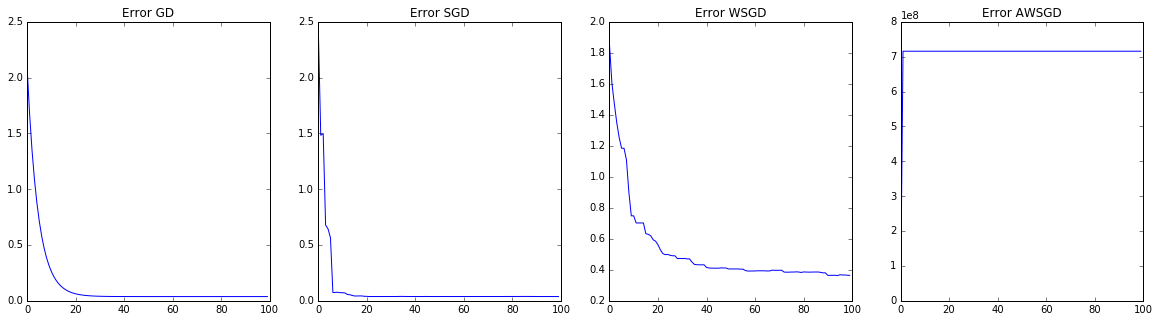

In [8]:
# Plot the Errors

plt.figure(figsize=(20,5))
z = np.arange(num_iter)
plt.subplot(1,4,1)
plt.plot(z,errors_gd)
plt.title('Error GD')
plt.subplot(1,4,2)
plt.plot(z,errors_sgd)
plt.title('Error SGD')
plt.subplot(1,4,3)
plt.plot(z,errors_wsgd)
plt.title('Error WSGD')
plt.subplot(1,4,4)
plt.plot(z,errors_awsgd)
plt.title('Error AWSGD')
plt.show()


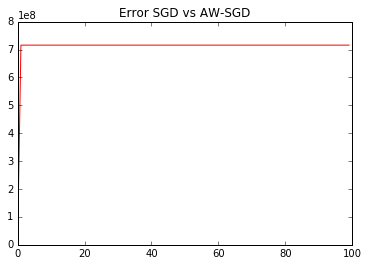

In [9]:
plt.plot(z,errors_sgd,c = 'blue')
plt.title('Error SGD vs AW-SGD')
plt.hold
plt.plot(z,errors_awsgd, c = 'red')
plt.show()

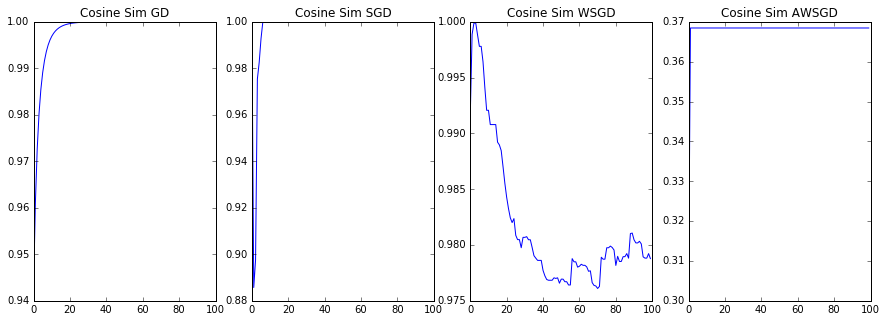

In [10]:
# Plot the cosine similarity with the true W.

plt.figure(figsize=(15,5))
z = np.arange(num_iter)
plt.subplot(1,4,1)
plt.plot(z,sim_gd)
plt.title('Cosine Sim GD')
plt.subplot(1,4,2)
plt.plot(z,sim_sgd)
plt.title('Cosine Sim SGD')
plt.subplot(1,4,3)
plt.plot(z,sim_wsgd)
plt.title('Cosine Sim WSGD')
plt.subplot(1,4,4)
plt.plot(z,sim_awsgd)
plt.title('Cosine Sim AWSGD')
plt.show()

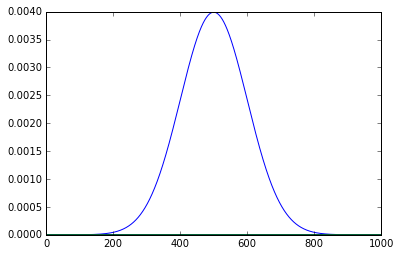

In [11]:
# Plot the Progression of the sampling distribution
for i in range(num_iter):
    m = np.linspace(0,N,N*100)
    p = norm.pdf(m,taus[i],N/10)
    plt.plot(m,p)
    plt.hold
plt.show()

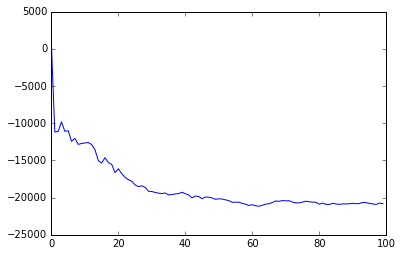

In [12]:
plt.plot(taus)

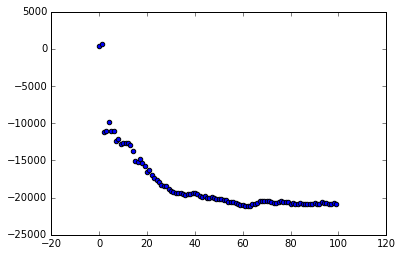

In [13]:
plt.scatter(np.arange(num_iter),zeds)

In [280]:
# Calculate the cosine similarties of the points and see which is best

similarities = np.zeros(N)

true_grad = lin_reg_grad(X,y,w_init)

for i in range(N):
    grad_estimate = lin_reg_grad(X[i:i+1,:],y[i],w_init)

cosine_similarity(grad_estimate,true_grad)
    

true_grad




array([[ 1.12925219],
       [ 1.18696124]])

In [132]:
np.shape(X[10,:])

(2,)

In [1]:
import climate
import downhill
import numpy as np
import theano
import theano.tensor as TT

climate.enable_default_logging()

def rand(a, b): return np.random.randn(a, b).astype('f')

A, B, K = 20, 5, 3

# Set up a matrix factorization problem to optimize.
u = theano.shared(rand(A, K), name='u')
v = theano.shared(rand(K, B), name='v')
e = TT.sqr(TT.matrix() - TT.dot(u, v))

# Minimize the regularized loss with respect to a data matrix.
y = np.dot(rand(A, K), rand(K, B)) + rand(A, B)

downhill.minimize(
    loss=e.mean() + abs(u).mean() + (v * v).mean(),
    train=[y],
    patience=0,
    batch_size=A,                 # Process y as a single batch.
    max_gradient_norm=1,          # Prevent gradient explosion!
    learning_rate=0.1,
    monitors=(('err', e.mean()),  # Monitor during optimization.
              ('|u|<0.1', (abs(u) < 0.1).mean()),
              ('|v|<0.1', (abs(v) < 0.1).mean())),
    monitor_gradients=True)

# Print out the optimized coefficients u and basis v.
print('u =', u.get_value())
print('v =', v.get_value())

INFO:downhill.dataset:train: 1 of 1 mini-batches from (20, 5)


I 2016-07-07 15:49:51 downhill.dataset:174 train: 1 of 1 mini-batches from (20, 5)


INFO:downhill.base:-- patience = 0


I 2016-07-07 15:49:51 downhill.base:389 -- patience = 0


INFO:downhill.base:-- validate_every = 10


I 2016-07-07 15:49:51 downhill.base:390 -- validate_every = 10


INFO:downhill.base:-- max_updates = None


I 2016-07-07 15:49:51 downhill.base:391 -- max_updates = None


INFO:downhill.base:-- min_improvement = 0


I 2016-07-07 15:49:51 downhill.base:392 -- min_improvement = 0


INFO:downhill.base:-- max_gradient_norm = 1


I 2016-07-07 15:49:51 downhill.base:393 -- max_gradient_norm = 1


INFO:downhill.base:-- max_gradient_elem = 0


I 2016-07-07 15:49:51 downhill.base:394 -- max_gradient_elem = 0


INFO:downhill.base:-- learning_rate = 0.1


I 2016-07-07 15:49:51 downhill.base:395 -- learning_rate = 0.1


INFO:downhill.base:-- momentum = 0


I 2016-07-07 15:49:51 downhill.base:396 -- momentum = 0


INFO:downhill.base:-- nesterov = False


I 2016-07-07 15:49:51 downhill.base:397 -- nesterov = False


INFO:downhill.adaptive:-- rms_halflife = 14


I 2016-07-07 15:49:51 downhill.adaptive:220 -- rms_halflife = 14


INFO:downhill.adaptive:-- rms_regularizer = 1e-08


I 2016-07-07 15:49:51 downhill.adaptive:221 -- rms_regularizer = 1e-08


INFO:downhill.base:compiling evaluation function


I 2016-07-07 15:49:51 downhill.base:118 compiling evaluation function


INFO:downhill.base:compiling RMSProp function


I 2016-07-07 15:50:03 downhill.base:124 compiling RMSProp function


INFO:downhill.base:validation 0 loss=5.875907 err=4.540981 |u|<0.1=0.066667 |v|<0.1=0.133333 grad(v)=1.766186 grad(u)=0.778860 *


I 2016-07-07 15:50:19 downhill.base:232 validation 0 loss=5.875907 err=4.540981 |u|<0.1=0.066667 |v|<0.1=0.133333 grad(v)=1.766186 grad(u)=0.778860 *


INFO:downhill.base:RMSProp 1 loss=5.875907 err=4.540981 |u|<0.1=0.066667 |v|<0.1=0.133333 grad(v)=1.766186 grad(u)=0.778860


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 1 loss=5.875907 err=4.540981 |u|<0.1=0.066667 |v|<0.1=0.133333 grad(v)=1.766186 grad(u)=0.778860


INFO:downhill.base:RMSProp 2 loss=3.599935 err=2.770614 |u|<0.1=0.083333 |v|<0.1=0.200000 grad(v)=0.161211 grad(u)=0.146888


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 2 loss=3.599935 err=2.770614 |u|<0.1=0.083333 |v|<0.1=0.200000 grad(v)=0.161211 grad(u)=0.146888


INFO:downhill.base:RMSProp 3 loss=3.163241 err=2.489223 |u|<0.1=0.166667 |v|<0.1=0.133333 grad(v)=0.063558 grad(u)=0.060468


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 3 loss=3.163241 err=2.489223 |u|<0.1=0.166667 |v|<0.1=0.133333 grad(v)=0.063558 grad(u)=0.060468


INFO:downhill.base:RMSProp 4 loss=2.925698 err=2.273789 |u|<0.1=0.250000 |v|<0.1=0.066667 grad(v)=0.011586 grad(u)=0.050720


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 4 loss=2.925698 err=2.273789 |u|<0.1=0.250000 |v|<0.1=0.066667 grad(v)=0.011586 grad(u)=0.050720


INFO:downhill.base:RMSProp 5 loss=2.771293 err=2.088483 |u|<0.1=0.200000 |v|<0.1=0.066667 grad(v)=0.022198 grad(u)=0.031960


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 5 loss=2.771293 err=2.088483 |u|<0.1=0.200000 |v|<0.1=0.066667 grad(v)=0.022198 grad(u)=0.031960


INFO:downhill.base:RMSProp 6 loss=2.650094 err=1.896720 |u|<0.1=0.250000 |v|<0.1=0.066667 grad(v)=0.012511 grad(u)=0.030314


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 6 loss=2.650094 err=1.896720 |u|<0.1=0.250000 |v|<0.1=0.066667 grad(v)=0.012511 grad(u)=0.030314


INFO:downhill.base:RMSProp 7 loss=2.564841 err=1.758069 |u|<0.1=0.150000 |v|<0.1=0.133333 grad(v)=0.007610 grad(u)=0.027490


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 7 loss=2.564841 err=1.758069 |u|<0.1=0.150000 |v|<0.1=0.133333 grad(v)=0.007610 grad(u)=0.027490


INFO:downhill.base:RMSProp 8 loss=2.486564 err=1.627358 |u|<0.1=0.183333 |v|<0.1=0.133333 grad(v)=0.006564 grad(u)=0.025311


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 8 loss=2.486564 err=1.627358 |u|<0.1=0.183333 |v|<0.1=0.133333 grad(v)=0.006564 grad(u)=0.025311


INFO:downhill.base:RMSProp 9 loss=2.415072 err=1.524319 |u|<0.1=0.150000 |v|<0.1=0.200000 grad(v)=0.006541 grad(u)=0.023743


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 9 loss=2.415072 err=1.524319 |u|<0.1=0.150000 |v|<0.1=0.200000 grad(v)=0.006541 grad(u)=0.023743


INFO:downhill.base:RMSProp 10 loss=2.343810 err=1.417606 |u|<0.1=0.233333 |v|<0.1=0.200000 grad(v)=0.007307 grad(u)=0.023718


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 10 loss=2.343810 err=1.417606 |u|<0.1=0.233333 |v|<0.1=0.200000 grad(v)=0.007307 grad(u)=0.023718


INFO:downhill.base:validation 1 loss=2.280968 err=1.322145 |u|<0.1=0.200000 |v|<0.1=0.200000 grad(v)=0.005309 grad(u)=0.026911 *


I 2016-07-07 15:50:19 downhill.base:232 validation 1 loss=2.280968 err=1.322145 |u|<0.1=0.200000 |v|<0.1=0.200000 grad(v)=0.005309 grad(u)=0.026911 *


INFO:downhill.base:RMSProp 11 loss=2.280968 err=1.322145 |u|<0.1=0.200000 |v|<0.1=0.200000 grad(v)=0.005309 grad(u)=0.026911


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 11 loss=2.280968 err=1.322145 |u|<0.1=0.200000 |v|<0.1=0.200000 grad(v)=0.005309 grad(u)=0.026911


INFO:downhill.base:RMSProp 12 loss=2.206108 err=1.212760 |u|<0.1=0.183333 |v|<0.1=0.200000 grad(v)=0.007822 grad(u)=0.023253


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 12 loss=2.206108 err=1.212760 |u|<0.1=0.183333 |v|<0.1=0.200000 grad(v)=0.007822 grad(u)=0.023253


INFO:downhill.base:RMSProp 13 loss=2.143547 err=1.108200 |u|<0.1=0.166667 |v|<0.1=0.066667 grad(v)=0.004180 grad(u)=0.023786


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 13 loss=2.143547 err=1.108200 |u|<0.1=0.166667 |v|<0.1=0.066667 grad(v)=0.004180 grad(u)=0.023786


INFO:downhill.base:RMSProp 14 loss=2.085339 err=1.029058 |u|<0.1=0.216667 |v|<0.1=0.133333 grad(v)=0.005305 grad(u)=0.019959


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 14 loss=2.085339 err=1.029058 |u|<0.1=0.216667 |v|<0.1=0.133333 grad(v)=0.005305 grad(u)=0.019959


INFO:downhill.base:RMSProp 15 loss=2.038661 err=0.950677 |u|<0.1=0.216667 |v|<0.1=0.133333 grad(v)=0.003796 grad(u)=0.019180


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 15 loss=2.038661 err=0.950677 |u|<0.1=0.216667 |v|<0.1=0.133333 grad(v)=0.003796 grad(u)=0.019180


INFO:downhill.base:RMSProp 16 loss=2.002167 err=0.903375 |u|<0.1=0.266667 |v|<0.1=0.066667 grad(v)=0.004247 grad(u)=0.015912


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 16 loss=2.002167 err=0.903375 |u|<0.1=0.266667 |v|<0.1=0.066667 grad(v)=0.004247 grad(u)=0.015912


INFO:downhill.base:RMSProp 17 loss=1.970705 err=0.843304 |u|<0.1=0.266667 |v|<0.1=0.133333 grad(v)=0.004924 grad(u)=0.012568


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 17 loss=1.970705 err=0.843304 |u|<0.1=0.266667 |v|<0.1=0.133333 grad(v)=0.004924 grad(u)=0.012568


INFO:downhill.base:RMSProp 18 loss=1.945026 err=0.828127 |u|<0.1=0.250000 |v|<0.1=0.066667 grad(v)=0.004590 grad(u)=0.013993


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 18 loss=1.945026 err=0.828127 |u|<0.1=0.250000 |v|<0.1=0.066667 grad(v)=0.004590 grad(u)=0.013993


INFO:downhill.base:RMSProp 19 loss=1.929324 err=0.787570 |u|<0.1=0.266667 |v|<0.1=0.066667 grad(v)=0.007736 grad(u)=0.012078


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 19 loss=1.929324 err=0.787570 |u|<0.1=0.266667 |v|<0.1=0.066667 grad(v)=0.007736 grad(u)=0.012078


INFO:downhill.base:RMSProp 20 loss=1.910094 err=0.774437 |u|<0.1=0.300000 |v|<0.1=0.000000 grad(v)=0.008011 grad(u)=0.010532


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 20 loss=1.910094 err=0.774437 |u|<0.1=0.300000 |v|<0.1=0.000000 grad(v)=0.008011 grad(u)=0.010532


INFO:downhill.base:validation 2 loss=1.900761 err=0.753212 |u|<0.1=0.250000 |v|<0.1=0.066667 grad(v)=0.012624 grad(u)=0.008483 *


I 2016-07-07 15:50:19 downhill.base:232 validation 2 loss=1.900761 err=0.753212 |u|<0.1=0.250000 |v|<0.1=0.066667 grad(v)=0.012624 grad(u)=0.008483 *


INFO:downhill.base:RMSProp 21 loss=1.900761 err=0.753212 |u|<0.1=0.250000 |v|<0.1=0.066667 grad(v)=0.012624 grad(u)=0.008483


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 21 loss=1.900761 err=0.753212 |u|<0.1=0.250000 |v|<0.1=0.066667 grad(v)=0.012624 grad(u)=0.008483


INFO:downhill.base:RMSProp 22 loss=1.884520 err=0.750528 |u|<0.1=0.283333 |v|<0.1=0.000000 grad(v)=0.012071 grad(u)=0.008434


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 22 loss=1.884520 err=0.750528 |u|<0.1=0.283333 |v|<0.1=0.000000 grad(v)=0.012071 grad(u)=0.008434


INFO:downhill.base:RMSProp 23 loss=1.875121 err=0.724898 |u|<0.1=0.266667 |v|<0.1=0.066667 grad(v)=0.011941 grad(u)=0.009880


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 23 loss=1.875121 err=0.724898 |u|<0.1=0.266667 |v|<0.1=0.066667 grad(v)=0.011941 grad(u)=0.009880


INFO:downhill.base:RMSProp 24 loss=1.871716 err=0.740554 |u|<0.1=0.300000 |v|<0.1=0.066667 grad(v)=0.014710 grad(u)=0.007642


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 24 loss=1.871716 err=0.740554 |u|<0.1=0.300000 |v|<0.1=0.066667 grad(v)=0.014710 grad(u)=0.007642


INFO:downhill.base:RMSProp 25 loss=1.861975 err=0.702337 |u|<0.1=0.300000 |v|<0.1=0.133333 grad(v)=0.019385 grad(u)=0.006563


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 25 loss=1.861975 err=0.702337 |u|<0.1=0.300000 |v|<0.1=0.133333 grad(v)=0.019385 grad(u)=0.006563


INFO:downhill.base:RMSProp 26 loss=1.866143 err=0.747450 |u|<0.1=0.350000 |v|<0.1=0.066667 grad(v)=0.027147 grad(u)=0.011754


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 26 loss=1.866143 err=0.747450 |u|<0.1=0.350000 |v|<0.1=0.066667 grad(v)=0.027147 grad(u)=0.011754


INFO:downhill.base:RMSProp 27 loss=1.876302 err=0.716036 |u|<0.1=0.300000 |v|<0.1=0.133333 grad(v)=0.039911 grad(u)=0.011448


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 27 loss=1.876302 err=0.716036 |u|<0.1=0.300000 |v|<0.1=0.133333 grad(v)=0.039911 grad(u)=0.011448


INFO:downhill.base:RMSProp 28 loss=1.868788 err=0.735541 |u|<0.1=0.283333 |v|<0.1=0.066667 grad(v)=0.039201 grad(u)=0.008732


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 28 loss=1.868788 err=0.735541 |u|<0.1=0.283333 |v|<0.1=0.066667 grad(v)=0.039201 grad(u)=0.008732


INFO:downhill.base:RMSProp 29 loss=1.856367 err=0.705306 |u|<0.1=0.350000 |v|<0.1=0.200000 grad(v)=0.031814 grad(u)=0.011359


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 29 loss=1.856367 err=0.705306 |u|<0.1=0.350000 |v|<0.1=0.200000 grad(v)=0.031814 grad(u)=0.011359


INFO:downhill.base:RMSProp 30 loss=1.858760 err=0.727562 |u|<0.1=0.283333 |v|<0.1=0.066667 grad(v)=0.031196 grad(u)=0.009496


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 30 loss=1.858760 err=0.727562 |u|<0.1=0.283333 |v|<0.1=0.066667 grad(v)=0.031196 grad(u)=0.009496


INFO:downhill.base:validation 3 loss=1.854054 err=0.682883 |u|<0.1=0.333333 |v|<0.1=0.200000 grad(v)=0.031582 grad(u)=0.008366 *


I 2016-07-07 15:50:19 downhill.base:232 validation 3 loss=1.854054 err=0.682883 |u|<0.1=0.333333 |v|<0.1=0.200000 grad(v)=0.031582 grad(u)=0.008366 *


INFO:downhill.base:RMSProp 31 loss=1.854054 err=0.682883 |u|<0.1=0.333333 |v|<0.1=0.200000 grad(v)=0.031582 grad(u)=0.008366


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 31 loss=1.854054 err=0.682883 |u|<0.1=0.333333 |v|<0.1=0.200000 grad(v)=0.031582 grad(u)=0.008366


INFO:downhill.base:RMSProp 32 loss=1.850058 err=0.730499 |u|<0.1=0.316667 |v|<0.1=0.066667 grad(v)=0.032111 grad(u)=0.008037


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 32 loss=1.850058 err=0.730499 |u|<0.1=0.316667 |v|<0.1=0.066667 grad(v)=0.032111 grad(u)=0.008037


INFO:downhill.base:RMSProp 33 loss=1.846542 err=0.683443 |u|<0.1=0.333333 |v|<0.1=0.200000 grad(v)=0.029244 grad(u)=0.010265


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 33 loss=1.846542 err=0.683443 |u|<0.1=0.333333 |v|<0.1=0.200000 grad(v)=0.029244 grad(u)=0.010265


INFO:downhill.base:RMSProp 34 loss=1.845850 err=0.724608 |u|<0.1=0.316667 |v|<0.1=0.066667 grad(v)=0.027795 grad(u)=0.006626


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 34 loss=1.845850 err=0.724608 |u|<0.1=0.316667 |v|<0.1=0.066667 grad(v)=0.027795 grad(u)=0.006626


INFO:downhill.base:RMSProp 35 loss=1.835608 err=0.679016 |u|<0.1=0.400000 |v|<0.1=0.200000 grad(v)=0.024380 grad(u)=0.008580


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 35 loss=1.835608 err=0.679016 |u|<0.1=0.400000 |v|<0.1=0.200000 grad(v)=0.024380 grad(u)=0.008580


INFO:downhill.base:RMSProp 36 loss=1.841233 err=0.720096 |u|<0.1=0.300000 |v|<0.1=0.066667 grad(v)=0.025601 grad(u)=0.008978


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 36 loss=1.841233 err=0.720096 |u|<0.1=0.300000 |v|<0.1=0.066667 grad(v)=0.025601 grad(u)=0.008978


INFO:downhill.base:RMSProp 37 loss=1.838217 err=0.679684 |u|<0.1=0.350000 |v|<0.1=0.200000 grad(v)=0.025318 grad(u)=0.011007


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 37 loss=1.838217 err=0.679684 |u|<0.1=0.350000 |v|<0.1=0.200000 grad(v)=0.025318 grad(u)=0.011007


INFO:downhill.base:RMSProp 38 loss=1.840841 err=0.705487 |u|<0.1=0.283333 |v|<0.1=0.133333 grad(v)=0.024713 grad(u)=0.005012


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 38 loss=1.840841 err=0.705487 |u|<0.1=0.283333 |v|<0.1=0.133333 grad(v)=0.024713 grad(u)=0.005012


INFO:downhill.base:RMSProp 39 loss=1.825896 err=0.680124 |u|<0.1=0.383333 |v|<0.1=0.200000 grad(v)=0.021076 grad(u)=0.004992


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 39 loss=1.825896 err=0.680124 |u|<0.1=0.383333 |v|<0.1=0.200000 grad(v)=0.021076 grad(u)=0.004992


INFO:downhill.base:RMSProp 40 loss=1.829243 err=0.701609 |u|<0.1=0.350000 |v|<0.1=0.133333 grad(v)=0.018113 grad(u)=0.008736


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 40 loss=1.829243 err=0.701609 |u|<0.1=0.350000 |v|<0.1=0.133333 grad(v)=0.018113 grad(u)=0.008736


INFO:downhill.base:validation 4 loss=1.832844 err=0.678388 |u|<0.1=0.316667 |v|<0.1=0.200000 grad(v)=0.016386 grad(u)=0.007855 *


I 2016-07-07 15:50:19 downhill.base:232 validation 4 loss=1.832844 err=0.678388 |u|<0.1=0.316667 |v|<0.1=0.200000 grad(v)=0.016386 grad(u)=0.007855 *


INFO:downhill.base:RMSProp 41 loss=1.832844 err=0.678388 |u|<0.1=0.316667 |v|<0.1=0.200000 grad(v)=0.016386 grad(u)=0.007855


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 41 loss=1.832844 err=0.678388 |u|<0.1=0.316667 |v|<0.1=0.200000 grad(v)=0.016386 grad(u)=0.007855


INFO:downhill.base:RMSProp 42 loss=1.827903 err=0.685325 |u|<0.1=0.316667 |v|<0.1=0.066667 grad(v)=0.019330 grad(u)=0.004481


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 42 loss=1.827903 err=0.685325 |u|<0.1=0.316667 |v|<0.1=0.066667 grad(v)=0.019330 grad(u)=0.004481


INFO:downhill.base:RMSProp 43 loss=1.829233 err=0.687731 |u|<0.1=0.383333 |v|<0.1=0.200000 grad(v)=0.021139 grad(u)=0.006803


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 43 loss=1.829233 err=0.687731 |u|<0.1=0.383333 |v|<0.1=0.200000 grad(v)=0.021139 grad(u)=0.006803


INFO:downhill.base:RMSProp 44 loss=1.831514 err=0.693295 |u|<0.1=0.366667 |v|<0.1=0.133333 grad(v)=0.022987 grad(u)=0.007882


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 44 loss=1.831514 err=0.693295 |u|<0.1=0.366667 |v|<0.1=0.133333 grad(v)=0.022987 grad(u)=0.007882


INFO:downhill.base:RMSProp 45 loss=1.832809 err=0.689536 |u|<0.1=0.333333 |v|<0.1=0.200000 grad(v)=0.024340 grad(u)=0.006671


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 45 loss=1.832809 err=0.689536 |u|<0.1=0.333333 |v|<0.1=0.200000 grad(v)=0.024340 grad(u)=0.006671


INFO:downhill.base:RMSProp 46 loss=1.830783 err=0.694585 |u|<0.1=0.333333 |v|<0.1=0.133333 grad(v)=0.022856 grad(u)=0.007902


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 46 loss=1.830783 err=0.694585 |u|<0.1=0.333333 |v|<0.1=0.133333 grad(v)=0.022856 grad(u)=0.007902


INFO:downhill.base:RMSProp 47 loss=1.827568 err=0.679975 |u|<0.1=0.366667 |v|<0.1=0.200000 grad(v)=0.018615 grad(u)=0.005444


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 47 loss=1.827568 err=0.679975 |u|<0.1=0.366667 |v|<0.1=0.200000 grad(v)=0.018615 grad(u)=0.005444


INFO:downhill.base:RMSProp 48 loss=1.828022 err=0.694670 |u|<0.1=0.350000 |v|<0.1=0.200000 grad(v)=0.019892 grad(u)=0.009820


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 48 loss=1.828022 err=0.694670 |u|<0.1=0.350000 |v|<0.1=0.200000 grad(v)=0.019892 grad(u)=0.009820


INFO:downhill.base:RMSProp 49 loss=1.838223 err=0.681714 |u|<0.1=0.283333 |v|<0.1=0.200000 grad(v)=0.025465 grad(u)=0.005411


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 49 loss=1.838223 err=0.681714 |u|<0.1=0.283333 |v|<0.1=0.200000 grad(v)=0.025465 grad(u)=0.005411


INFO:downhill.base:RMSProp 50 loss=1.830096 err=0.693359 |u|<0.1=0.366667 |v|<0.1=0.200000 grad(v)=0.027129 grad(u)=0.006829


I 2016-07-07 15:50:19 downhill.base:232 RMSProp 50 loss=1.830096 err=0.693359 |u|<0.1=0.366667 |v|<0.1=0.200000 grad(v)=0.027129 grad(u)=0.006829


INFO:downhill.base:validation 5 loss=1.836166 err=0.689789 |u|<0.1=0.366667 |v|<0.1=0.200000 grad(v)=0.027648 grad(u)=0.008700


I 2016-07-07 15:50:19 downhill.base:232 validation 5 loss=1.836166 err=0.689789 |u|<0.1=0.366667 |v|<0.1=0.200000 grad(v)=0.027648 grad(u)=0.008700


INFO:downhill.base:patience elapsed!


I 2016-07-07 15:50:19 downhill.base:414 patience elapsed!
('u =', array([[ -3.18959022e+00,  -1.55650043e+00,   1.25228256e-01],
       [  1.49464583e+00,  -1.10656023e-03,   2.36193347e+00],
       [  5.02728939e-01,   1.96595931e+00,   4.50359657e-02],
       [ -6.33716285e-01,   1.26184070e+00,  -1.32035410e+00],
       [ -1.70202881e-01,   5.56546152e-02,  -9.29425538e-01],
       [  1.27949774e+00,   5.59897572e-02,  -8.53152946e-03],
       [  3.15853208e-01,   1.38277352e+00,  -7.25604407e-03],
       [ -2.00586963e+00,   1.13515997e+00,  -3.91623974e-02],
       [ -1.68593359e+00,   5.92828631e-01,   9.57718119e-02],
       [ -6.82622194e-04,   9.23861042e-02,  -4.97543395e-01],
       [ -1.60177350e-01,  -1.41539332e-02,   3.28974843e+00],
       [ -1.80730358e-01,   1.38905203e+00,   1.74537867e-01],
       [  6.27478600e-01,  -6.43601865e-02,   9.45688367e-01],
       [ -1.97225690e+00,  -3.65263447e-02,   1.92878380e-01],
       [ -8.17843601e-02,  -2.79370403e+00,   7.4486

In [ ]:
class discrete_distribution(object):
    """ Discrete probability distribuiton on the range [1,N]
    """
    
    def __init__(self,probs):
        """Probs is a np array of probabilites"""
        self.Z = float(np.sum(probs))
        self.probs = probs/self.Z
        self.cumsum = np.cumsum(self.probs)
    
    def probability(self,index):
        return self.probs[index]
    
    def sample(self):
        seed = np.random.random()
        smp = 0
        while(seed > self.cumsum[smp]):
            smp = smp + 1
        return smp
    
    def update_prob(self,index,prob):
        self.probs = self.probs*self.Z
        self.Z = self.Z - self.probs[index] + prob
        self.probs[index] = prob
        self.probs = self.probs/float(self.Z)
        self.cumsum = np.cumsum(self.probs)

In [15]:
np.random.normal?